In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/models_02.py --output models_02.py
!curl $URL_BASE/test_models_02.py --output test_models_02.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0   7375      0 --:--:-- --:--:-- --:--:--  7375
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   2012      0 --:--:-- --:--:-- --:--:--  2012
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2992  100  2992    0     0   9094      0 --:--:-- --:--:-- --:--:--  9094
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5417  100  5417    0     0  16074      0 --:--:-- --:--:-- --:--:-- 16026
  % Total    % Received % Xferd  Average Speed   Tim

In [49]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more
from tqdm import tqdm

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_03 import BrainNetv1R, BrainResNet, BrainNetv2R, BrainNetv3R, BrainNetv4R

ImportError: ignored

# Preprocessing Dataset | (from .mat to .npy) 📥
Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [9]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in tqdm(range(3064)):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

100%|██████████| 3064/3064 [00:56<00:00, 53.83it/s]


save Labels

In [10]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

# Config Device and Seed 🖥 🎲

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [12]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Load Dataset and Create DataLoaders 💽

In [33]:
# Load Dataset
BATCH_SIZE = 32
TEST_BATCH_SIZE = 16
EPOCHS = 10
HEADERS = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']

dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = plots.split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [14]:
# Split train_data for training and validation
train_set, val_set = plots.split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [35]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  39


# Visualization of Dataset 👀

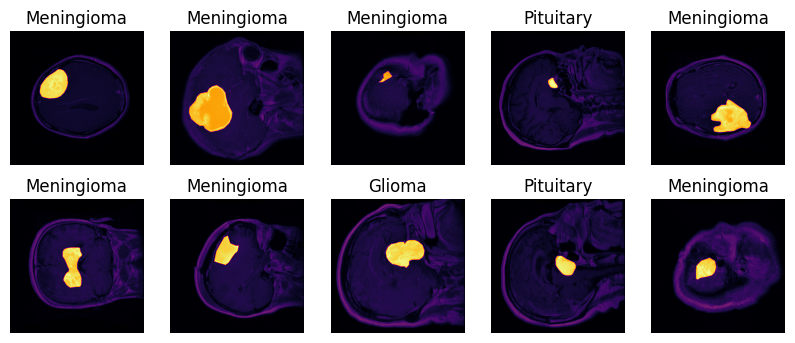

In [16]:
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()

  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(CLASS_NAMES[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

# Testing

In [17]:
!python -m pytest test_models_03.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.2.0
rootdir: /content
plugins: anyio-3.7.0
collected 5 items                                                              

test_models_03.py .....                                                  [100%]

============================== 5 passed in 13.05s ==============================


# Training 💪 🏋️

# Brain Net V1R

In [36]:
model = BrainNetv1R()
brainnet_v1_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

brainnet_v1_ckp = ModelCheckpoint('brainnet_v1_lr3.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v1_ckp)

brainnet_v1_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/10): time=00:23, train_loss=0.448, train_acc=0.817, train_f1=0.812, val_loss=2.003, val_acc=0.582, val_f1=0.580


Epoch 2/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/10): time=00:23, train_loss=0.226, train_acc=0.914, train_f1=0.914, val_loss=3.285, val_acc=0.472, val_f1=0.372


Epoch 3/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/10): time=00:22, train_loss=0.214, train_acc=0.923, train_f1=0.923, val_loss=0.940, val_acc=0.659, val_f1=0.606


Epoch 4/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/10): time=00:22, train_loss=0.167, train_acc=0.941, train_f1=0.941, val_loss=0.331, val_acc=0.882, val_f1=0.888


Epoch 5/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/10): time=00:22, train_loss=0.129, train_acc=0.949, train_f1=0.949, val_loss=0.239, val_acc=0.911, val_f1=0.913


Epoch 6/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/10): time=00:22, train_loss=0.115, train_acc=0.957, train_f1=0.957, val_loss=0.120, val_acc=0.954, val_f1=0.954


Epoch 7/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/10): time=00:22, train_loss=0.096, train_acc=0.967, train_f1=0.967, val_loss=0.118, val_acc=0.952, val_f1=0.953


Epoch 8/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/10): time=00:22, train_loss=0.132, train_acc=0.949, train_f1=0.949, val_loss=0.146, val_acc=0.956, val_f1=0.955


Epoch 9/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/10): time=00:22, train_loss=0.070, train_acc=0.978, train_f1=0.978, val_loss=0.269, val_acc=0.898, val_f1=0.897


Epoch 10/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/10): time=00:22, train_loss=0.075, train_acc=0.975, train_f1=0.975, val_loss=0.145, val_acc=0.941, val_f1=0.943


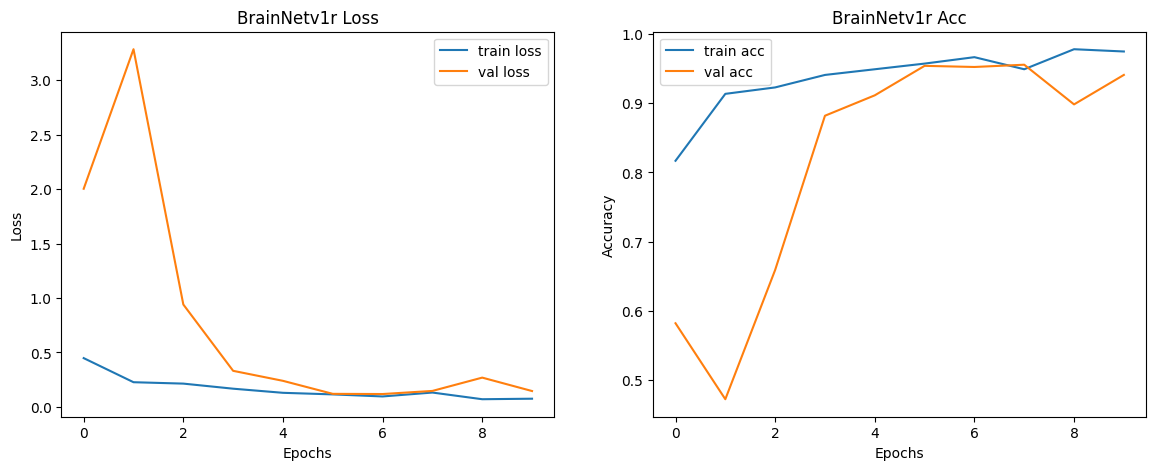

In [37]:
plots.plot_model_results("BrainNetv1r", brainnet_v1_results)

In [38]:
plots.print_table(HEADERS,
  [plots.row("BrainNet V1R", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params]]

)

+--------------+------------+----------+-----------+---------+----------+
|    Model     | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+--------------+------------+----------+-----------+---------+----------+
| BrainNet V1R |   0.096    |  0.118   |   0.967   |  0.952  |  413047  |
+--------------+------------+----------+-----------+---------+----------+


# Brain Net V3R

In [46]:
model = BrainNetv3R()
brainnet_v3_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

brainnet_v3_ckp = ModelCheckpoint('brainnet_v3_lr3.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v3_ckp)

brainnet_v3_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/10): time=00:32, train_loss=0.412, train_acc=0.830, train_f1=0.829, val_loss=0.336, val_acc=0.848, val_f1=0.823


Epoch 2/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/10): time=00:31, train_loss=0.215, train_acc=0.920, train_f1=0.920, val_loss=1.448, val_acc=0.639, val_f1=0.572


Epoch 3/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/10): time=00:31, train_loss=0.181, train_acc=0.932, train_f1=0.932, val_loss=0.205, val_acc=0.911, val_f1=0.911


Epoch 4/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/10): time=00:31, train_loss=0.147, train_acc=0.947, train_f1=0.947, val_loss=0.286, val_acc=0.902, val_f1=0.893


Epoch 5/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/10): time=00:30, train_loss=0.127, train_acc=0.951, train_f1=0.951, val_loss=0.219, val_acc=0.918, val_f1=0.912


Epoch 6/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/10): time=00:31, train_loss=0.085, train_acc=0.971, train_f1=0.971, val_loss=0.209, val_acc=0.921, val_f1=0.916


Epoch 7/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/10): time=00:30, train_loss=0.100, train_acc=0.966, train_f1=0.965, val_loss=0.470, val_acc=0.818, val_f1=0.820


Epoch 8/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/10): time=00:30, train_loss=0.144, train_acc=0.950, train_f1=0.950, val_loss=0.778, val_acc=0.746, val_f1=0.741


Epoch 9/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/10): time=00:30, train_loss=0.087, train_acc=0.971, train_f1=0.971, val_loss=0.871, val_acc=0.715, val_f1=0.722


Epoch 10/10:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/10): time=00:30, train_loss=0.063, train_acc=0.978, train_f1=0.978, val_loss=2.938, val_acc=0.434, val_f1=0.411


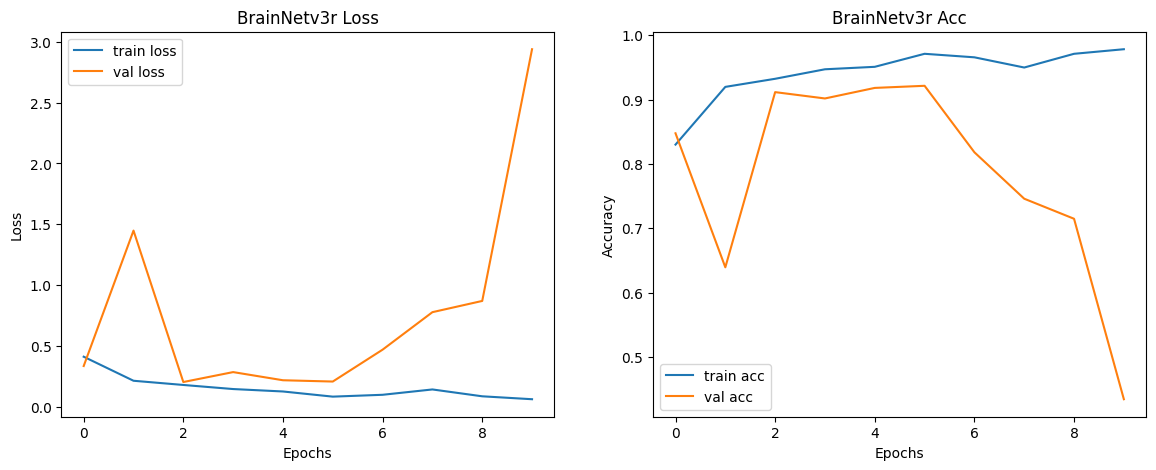

In [47]:
plots.plot_model_results("BrainNetv3r", brainnet_v3_results)

In [48]:
plots.print_table(HEADERS,
  [plots.row("BrainNet V1R", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params],
   plots.row("BrainNet V3R", brainnet_v3_ckp.best_results) + [brainnet_v3_num_params]]
)

+--------------+------------+----------+-----------+---------+----------+
|    Model     | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+--------------+------------+----------+-----------+---------+----------+
| BrainNet V1R |   0.096    |  0.118   |   0.967   |  0.952  |  413047  |
| BrainNet V3R |   0.181    |  0.205   |   0.932   |  0.911  |  427339  |
+--------------+------------+----------+-----------+---------+----------+


# Brain RESNET

In [18]:
train_dl_TEST = data.DataLoader(train_set, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [21]:
model = BrainResNet()
BrainResNet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())


parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

BrainResNet_lr4_wr8_ckp = ModelCheckpoint('BrainResNet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(BrainResNet_lr4_wr8_ckp, three_channels=True)
brainresnet_lr4_wr8_results = trainer.train(train_dl_TEST, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/10): time=02:10, train_loss=0.381, train_acc=0.853, train_f1=0.853, val_loss=2.692, val_acc=0.725, val_f1=0.651, lr=0.001


Epoch 2/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/10): time=02:02, train_loss=0.312, train_acc=0.886, train_f1=0.886, val_loss=2.504, val_acc=0.652, val_f1=0.581, lr=0.001


Epoch 3/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/10): time=01:59, train_loss=0.272, train_acc=0.901, train_f1=0.901, val_loss=0.937, val_acc=0.708, val_f1=0.650, lr=0.001


Epoch 4/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/10): time=02:01, train_loss=0.197, train_acc=0.929, train_f1=0.929, val_loss=0.402, val_acc=0.846, val_f1=0.855, lr=0.001


Epoch 5/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/10): time=01:53, train_loss=0.174, train_acc=0.933, train_f1=0.933, val_loss=0.232, val_acc=0.910, val_f1=0.909, lr=0.001


Epoch 6/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/10): time=01:52, train_loss=0.168, train_acc=0.940, train_f1=0.940, val_loss=0.287, val_acc=0.870, val_f1=0.866, lr=0.001


Epoch 7/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/10): time=01:51, train_loss=0.155, train_acc=0.945, train_f1=0.945, val_loss=0.354, val_acc=0.872, val_f1=0.871, lr=0.001


Epoch 8/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/10): time=01:50, train_loss=0.107, train_acc=0.960, train_f1=0.960, val_loss=0.642, val_acc=0.825, val_f1=0.789, lr=0.001


Epoch 9/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/10): time=01:49, train_loss=0.078, train_acc=0.970, train_f1=0.970, val_loss=0.159, val_acc=0.949, val_f1=0.949, lr=0.000


Epoch 10/10:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/10): time=01:47, train_loss=0.066, train_acc=0.980, train_f1=0.980, val_loss=0.285, val_acc=0.907, val_f1=0.907, lr=0.000


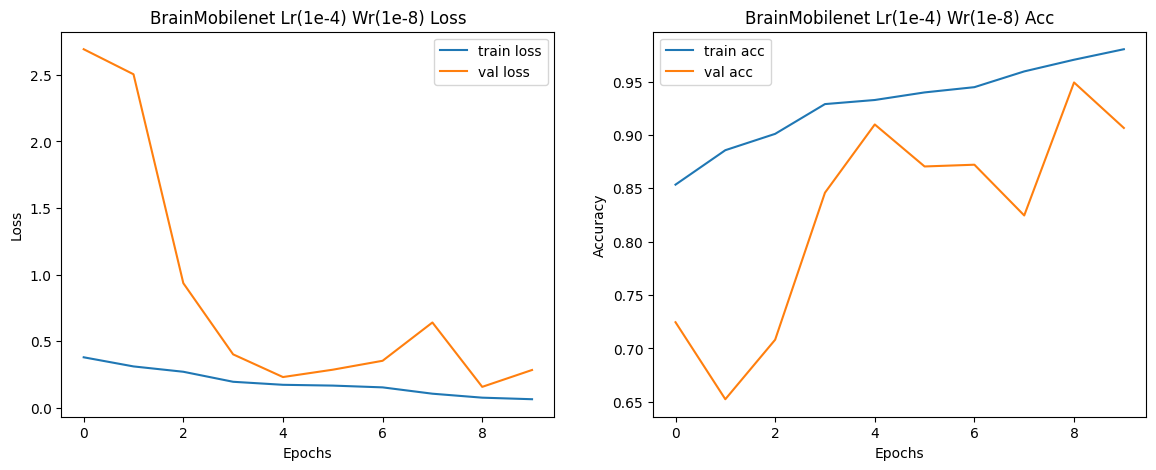

In [22]:
plots.plot_model_results("BrainMobilenet Lr(1e-4) Wr(1e-8)", brainresnet_lr4_wr8_results)

In [51]:
plots.print_table(HEADERS,
[
plots.row("BrainNet V1", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params],
  plots.row("BrainNet V3", brainnet_v3_ckp.best_results) + [brainnet_v3_num_params],
plots.row("BrainResNet",BrainResNet_lr4_wr8_ckp.best_results)+[BrainResNet_lr4_wr8_num_params]
])

+-------------+------------+----------+-----------+---------+----------+
|    Model    | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------+------------+----------+-----------+---------+----------+
| BrainNet V1 |   0.096    |  0.118   |   0.967   |  0.952  |  413047  |
| BrainNet V3 |   0.181    |  0.205   |   0.932   |  0.911  |  427339  |
| BrainResNet |   0.078    |  0.159   |   0.970   |  0.949  | 23514179 |
+-------------+------------+----------+-----------+---------+----------+


In [24]:
best_model = BrainResNet()
best_model = best_model.to(device)
BrainResNet_lr4_wr8_ckp.load_checkpoint(best_model)

In [25]:
def predict_labels(model, test_dl):
  y_pred = []
  y_true = []

  model.eval()

  with torch.no_grad():
    for X, y in test_dl:
      X = torch.concat([X, X.mean(1, keepdim=True)], 1)
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      y_pred.append(logits.detach().to('cpu'))
      y_true.append(y.detach().to('cpu'))
  return torch.concat(y_pred), torch.concat(y_true)

In [26]:
y_test_pred, y_test_true = predict_labels(best_model, test_dl)

In [27]:
print(f"Predictions size: {y_test_pred.size()}")
print(f"True Labels size: {y_test_true.size()}")

Predictions size: torch.Size([610, 3])
True Labels size: torch.Size([610])


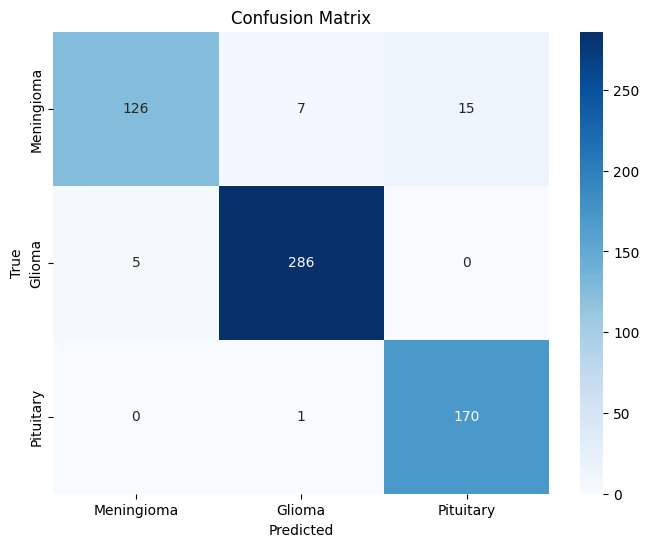

In [28]:
import torchmetrics
import seaborn as sns
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
  confusion_matrix = torchmetrics.ConfusionMatrix('multiclass', num_classes=3)
  confusion_matrix = confusion_matrix.to('cpu')
  cm = confusion_matrix(predicted_labels, true_labels).to('cpu')

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
plot_confusion_matrix(y_test_true, y_test_pred, CLASS_NAMES)